In [2]:
#imports
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.cluster import KMeans

In [3]:
#import data
voqs = pd.read_excel("./test_set_11_20.xlsx", sheetname=0)
voqs.columns = ["odino", "make_mod", "ecode", "compdesc", "cdescr", "defect", "datea", "modelyr", "engine_code"]
voqs.head()

,odino,make_mod,ecode,compdesc,cdescr,defect,datea,modelyr,engine_code
0,11046596,bmw; k1300 gt; 2010; motorcycle; wb1053906az,k44,fuel/propulsion system,tl* the contact owns a 2010 bmw k1300 gt motor...,1747 - (moto) quick-connect fuel line issue,2017-11-16,2010,NaN
1,11045158,bmw; 323i; 1998; car; m52; wbabj8321we,e36,air bags; engine; unknown or other,"a driver, on a 5 lane st, in a center turn lan...",1002 - airbag related injuries,2017-11-10,1998,m52
2,11046601,bmw; 320i; 2016; car; n20; wba8e1g58gn,f30,electrical system; power train; service brakes,car has shut off while in motion and indicator...,1112 - multiple issues,2017-11-16,2016,n20
3,11046895,bmw; 760li; 2006; car; n73; wbahn03566d,e66,electrical system; power train; suspension,"car stops on freeway, numerous problems with s...",1112 - multiple issues,2017-11-17,2006,n73
4,11046876,bmw; x3; 2013; car; n20; 5uxwx9c54d0,f25,exterior lighting,tail lights will fail with no warning light or...,1012 - tail light issue,2017-11-16,2013,n20


In [4]:
#trim sets for what you need
narratives = voqs['cdescr'].values.tolist()
defect_labels = voqs['defect'].values.tolist()
print(narratives[0][:200]) 

tl* the contact owns a 2010 bmw k1300 gt motorcycle. while driving approximately 50 mph, the contact noticed that his pants were wet from fuel that was leaking from a plastic connector line. the conta


In [10]:
#not finalized
#stop words and stemming instanced in respective variables
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")

In [11]:
# brandon rose's functions for tokenizing and stemming

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [12]:
#create two massive lists of total vocabulary in all the voqs

totalvocab_stemmed = []
totalvocab_tokenized = []
for i in narratives:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'narratives', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [19]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 1439449 items in vocab_frame


In [20]:
#convert documents to tfidf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
#word should not be in more than 80% of the documents
#word should be in at least 5% of the documents
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.05, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(narratives) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

Wall time: 39.5 s
(15489, 191)


In [24]:
#inspect the terms that are in the tfidf matrix
terms = tfidf_vectorizer.get_feature_names()
terms

["'s",
 '*tr',
 'abl',
 'accid',
 'air',
 'air bag',
 'airbag',
 'ani',
 'approxim',
 'approxim failur',
 'approxim failur mileag',
 'assist',
 'avail',
 'awar',
 'bag',
 'becaus',
 'befor',
 'bmw',
 'brake',
 'came',
 'campaign',
 'campaign number',
 'car',
 'caus',
 'check',
 'come',
 'complaint',
 'complet',
 'contact',
 'contact bmw',
 'contact experienc',
 'contact experienc failur',
 'contact receiv',
 'contact receiv notif',
 'contact state',
 'contact state manufactur',
 'continu',
 'control',
 'cooper',
 'cost',
 'cover',
 'current',
 'current mileag',
 'danger',
 'day',
 'dealer',
 'dealership',
 'defect',
 'diagnos',
 'did',
 'doe',
 'door',
 'drive',
 'driver',
 'engin',
 'exceed',
 'exceed reason',
 'exceed reason time',
 'experienc',
 'experienc failur',
 'fail',
 'failur',
 'failur mileag',
 'fix',
 'fuel',
 'happen',
 'highway',
 'howev',
 'illumin',
 'includ',
 'indic',
 'inform',
 'issu',
 'just',
 'know',
 'later',
 'leak',
 'left',
 'light',
 'like',
 'lock',
 'make

In [25]:
#cosine similarity if necessary later
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist

<function print>

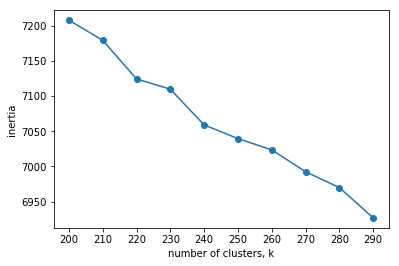

In [38]:
#compute within cluster sum of squares (inertia) for each k between 2 and 10 and plot to pick the best K
import matplotlib.pyplot as plt

ks = range(200, 300, 10)
inertia_values = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(tfidf_matrix)
    
    # Append the inertia to the list of inertias
    inertia_values.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertia_values, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.savefig('inertia2.jpg')
plt.show()

In [39]:
#try an optimized clustering 
from sklearn.cluster import KMeans

num_clusters = 250

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

Wall time: 2min 20s


In [42]:
#add cluster labels onto original dataframe
voqs['clusters'] = clusters
voqs

,odino,make_mod,ecode,compdesc,cdescr,defect,datea,modelyr,engine_code,clusters
0,11046596,bmw; k1300 gt; 2010; motorcycle; wb1053906az,k44,fuel/propulsion system,tl* the contact owns a 2010 bmw k1300 gt motor...,1747 - (moto) quick-connect fuel line issue,2017-11-16,2010,NaN,206
1,11045158,bmw; 323i; 1998; car; m52; wbabj8321we,e36,air bags; engine; unknown or other,"a driver, on a 5 lane st, in a center turn lan...",1002 - airbag related injuries,2017-11-10,1998,m52,102
2,11046601,bmw; 320i; 2016; car; n20; wba8e1g58gn,f30,electrical system; power train; service brakes,car has shut off while in motion and indicator...,1112 - multiple issues,2017-11-16,2016,n20,96
3,11046895,bmw; 760li; 2006; car; n73; wbahn03566d,e66,electrical system; power train; suspension,"car stops on freeway, numerous problems with s...",1112 - multiple issues,2017-11-17,2006,n73,170
4,11046876,bmw; x3; 2013; car; n20; 5uxwx9c54d0,f25,exterior lighting,tail lights will fail with no warning light or...,1012 - tail light issue,2017-11-16,2013,n20,45
5,11046635,bmw; r1200 r; 2007; motorcycle; wb10398007z,k27,fuel/propulsion system,driving on the highway with fuel indicator sho...,1710 - (moto) fuel gauge read incorrectly,2017-11-16,2007,NaN,15
6,11046571,bmw; 3 series; 2007; car; n52k; wbavc93517k,e90,engine,vehicle completely shut down while driving on ...,1042 - defective vanos bolts,2017-11-16,2007,n52k,126
7,11046648,bmw; 335i; 2009; car; n54; wbawl73589p,e93,air bags; engine; fuel/propulsion system,i went to the bmw dealership (to have the seve...,1467 - no replacement parts,2017-11-16,2009,n54,126
8,11046486,bmw; x5 sav; 2009; car; m57y; 5uxff03593l,e70,engine; fuel/propulsion system,i am writing in regards to a technical service...,1467 - no replacement parts,2017-11-16,2009,m57y,50
9,11046505,bmw; 530i; 2017; car; b46o; wbaja5c33hg,g30,visibility/wiper,tl* the contact owns a 2017 (na) bmw 530i. whi...,1746 - heads up display causes glare on windsh...,2017-11-16,2017,b46o,49


In [49]:
#inspect clustering
#voqs.sort_values(columns=['clusters'])
#voqs
voqs.to_csv('inspect.csv', sep=',')